## Statoil/C-CORE Iceberg Classifier Challenge

Fall 2017 | CSE627 | Dr. Femiani

Shrawani Silwal | Urvashi Desai

Group name on Kaggle : MU-CSE627-FEM-US

# Problem Description

Statoil, an international energy company operating worldwide,incollaboration with companies like C-CORE which has satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.

In this report, our team tries to analysize the problem and build a model that can automatically identify if a remotely sensed object is a ship or iceberg.

In [1]:
%pylab inline
# to plot features based on their number
import seaborn     as sns                
import pandas      as pd
import plotly.offline as py             
import plotly.graph_objs as go
py.init_notebook_mode(connected = True)
from mpl_toolkits.mplot3d import Axes3D  
from subprocess import check_output     
from sklearn.model_selection import train_test_split  
# for clearing images
from skimage.restoration import (denoise_tv_chambolle,
                                 denoise_bilateral,
                                 denoise_wavelet,
                                 estimate_sigma,
                                 denoise_tv_bregman,
                                 denoise_nl_means)
from skimage.filters import gaussian,sobel, rank
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.util import img_as_ubyte, invert
from skimage.morphology import disk,reconstruction
from skimage import img_as_float
from scipy.ndimage import gaussian_filter
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value

#Import Keras.
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, \
                        Dense, Merge, merge, Dropout, Input, Flatten, Activation, GlobalMaxPooling2D
#from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import plot_model
import os



Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Reading in the Data
We will begin with reading in our data and get an idea of what it looks like. There are two data sets, the test data and the training data in json format. The training data is what we will use to build our models that help us determine if a floating object is a ship or iceberg, and the testing data is the data we will predict, and eventually submit to Kaggle to obtain a score.


In [2]:
#load the data from local machine which is in json format
train = pd.read_json("train.json")
test  = pd.read_json("test.json")


# Data Viewing

## Understanding the data
Sentinet -1 sat is at about 680 Km above earth. Sending pulses of signals at a particular angle of incidence and then recoding it back. Here we see the data in the form of those reflected signals are called backscatter. 
the backstatter coefficient that has been provided as train and test data should vary with the surface on which the signal is scattered from, for a particular angle of incidence.Here we are dealing with two channels of data: HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). 

Let us visualize the data below and see what it looks like.
We can observe from the below images that is impossible to make any distinction by just looking at it with naked eye. 

Text(0.5,0.98,'SHIPS')

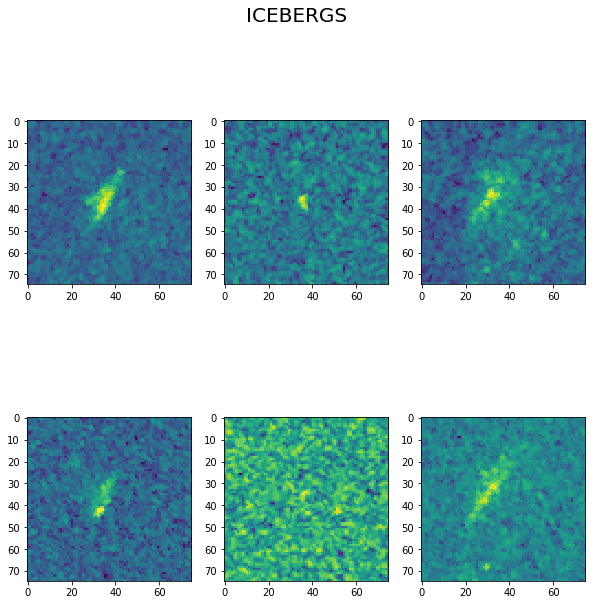

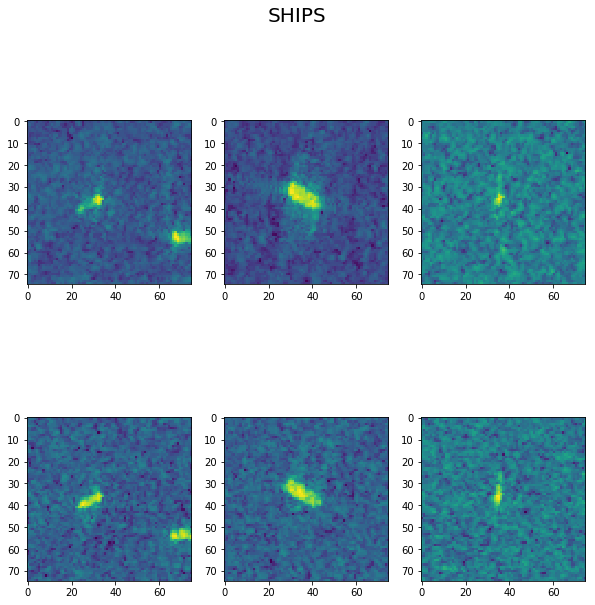

In [3]:

def plot_image(image):
    plt.imshow(image)

# lets get some random icebergs
plot = train.loc[train['is_iceberg'] == True].sample(3)

plt.figure(figsize=(10,10))
for i in range(3):
    # Set the current subplot
    plt.subplot(2,3,(i+1))
    # Reshape the array to 75x75
    image = np.array(plot.iloc[i]['band_1']).reshape((75,75)).astype(np.float32)
    plot_image(image)
    plt.subplot(2,3,(i+4))
    image = np.array(plot.iloc[i]['band_2']).reshape((75,75)).astype(np.float32)
    plot_image(image)
    
# Set the title
plt.suptitle('ICEBERGS',fontsize=20)

plot = train.loc[train['is_iceberg'] == False].sample(3)

plt.figure(figsize=(10,10))
for i in range(3):
     # Set the current subplot
    plt.subplot(2,3,(i+1))
    # Reshape the array to 75x75
    image = np.array(plot.iloc[i]['band_1']).reshape((75,75)).astype(np.float32)
    plot_image(image)
    plt.subplot(2,3,(i+4))
    image = np.array(plot.iloc[i]['band_2']).reshape((75,75)).astype(np.float32)
    plot_image(image)
    
plt.suptitle('SHIPS', fontsize=20)

In [41]:
#Take a closer look at an iceberg
import plotly.offline as py
import plotly.graph_objs as go
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:], 'iceberg')

As evident from above figure, we obtain a mountain like shape for the iceberg from the  radar data. Since this is just an image representation of backscatter from radar, the shape is going to have peaks and distortions like these.

In [32]:
plotmy3d(X_band_1[14,:,:], 'Ship')

For the ship the shape  may be like an elongated point. Thus on suh a close observation we can notice the structural differences  which can be exploited.

# Solution

## Keras Sequential model
We begin with defining our model here that is Keras Sequential model, and build linear stacks of layers. The model includes four layers of convolution operation along with activation equal to Rectified Linear Unit(ReLU), a layer to flatten the data for the preceeding dense layers, two dense layers which also uses ReLU as activation and finally a sigmoid layer. We use Adam as an optimization algorithm instead of the classical stochastic gradient to update the network weights.

In [16]:

#define our model
def getModel(input_shape = 3):
    #Building the model
    gmodel = Sequential()
    
    #Conv Layer 1
    if (input_shape == 4):
        gmodel.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (75, 75, 4)))
    else:
         gmodel.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (75, 75, 3)))   
    gmodel.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu' ))
    gmodel.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
    gmodel.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    gmodel.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
    gmodel.compile(loss     = 'binary_crossentropy',
                  optimizer = mypotim,
                  metrics   =['accuracy'])
    gmodel.summary()
    return gmodel



We prepare the input data by taking the two bands (band_1 and band_2) and averaging them. 

In [ ]:
# first approach with averaging band_1 and band2
def get_callbacks(filepath, patience = 2):
    es = EarlyStopping('val_loss', patience = patience, mode = "min")
    msave = ModelCheckpoint(filepath, save_best_only = True)
    return [es, msave]
X_band_1 = array([array(band).astype(float32).reshape(75, 75) for band in train.band_1])
X_band_2 = array([array(band).astype(float32).reshape(75, 75) for band in train.band_2])

X_train = concatenate([X_band_1[:, :, :, newaxis], X_band_2[:, :, :, newaxis],
                      ((X_band_1 + X_band_2) / 2)[:, :, :, np.newaxis]], axis = -1)

file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath = file_path, patience = 5)



target_train = train.is_iceberg
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    target_train, 
                                                    random_state = 1, 
                                                    test_size = 0.1)
                                                    
gmodel = getModel()
gmodel.fit(X_train, y_train,
          batch_size = 24,
          epochs = 50,
          verbose = 1,
          validation_data = (X_test, y_test),
          callbacks = callbacks)
          
          
          

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [ ]:

gmodel.load_weights(filepath = file_path)
score = gmodel.evaluate(X_test, y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



X_band_test_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test.band_1])
X_band_test_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test.band_2])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1 + X_band_test_2) / 2)[:, :, :, np.newaxis]], axis = -1)
predicted_test = gmodel.predict_proba(X_test)




submission               = pd.DataFrame()
submission['id']         = test['id']
submission['is_iceberg'] = predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub_04.csv', index = False)

We try to improve the score by making the images bolder and then passing it as feature to our network.

In [ ]:
#Making images bolder
avg_Band = array([array(band).astype(float32).reshape(75, 75) for band in train.band_1])

for i in range(len(X_band_1)):
    for j in range(len(X_band_1[i])):
        for z in range(len(X_band_1[i][j])):
            avg_Band[i][j][z] = (X_band_1[i][j][z] + X_band_2[i][j][z]) / 2
            
# Bolding band_1
X2_train = concatenate(
                        [X_band_1[:, :, :, newaxis], 
                         X_band_2[:, :, :, newaxis],
                         avg_Band[:, :, :, newaxis],
                        ((X_band_1 * 0.299) + (X_band_2 * 0.587) + (avg_Band * 0.114))[:, :, :, np.newaxis]],
                        axis = -1
                        )
print(X2_train.shape)

def get_callbacks(filepath, patience = 2):
    msave = ModelCheckpoint(filepath, save_best_only = True)
    return [msave]

file_path = ".model_result.hdf5"
callbacks = get_callbacks(filepath = file_path, patience = 5)

target_train = train.is_iceberg
X_train, X_test, y_train, y_test = train_test_split(X2_train, 
                                                    target_train, 
                                                    random_state = 1, 
                                                    test_size = 0.10)

#Without denoising, core features.
gmodel = getModel(4)
gmodel.fit(X_train, y_train,
          batch_size = 24,
          epochs = 50,
          verbose = 1,
          validation_data = (X_test, y_test),
          callbacks = callbacks)



In [20]:
X_band_test_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test.band_1])
X_band_test_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test.band_2])
test_avg_Band = array([array(band).astype(float32).reshape(75, 75) for band in test.band_1])

for i in range(len(X_band_test_1)):
    for j in range(len(X_band_test_1[i])):
        for z in range(len(X_band_test_1[i][j])):
            test_avg_Band[i][j][z] = (X_band_test_1[i][j][z] + X_band_test_2[i][j][z]) / 2
            
# Bolding band_1
X2_test = concatenate(
                        [X_band_test_1[:, :, :, newaxis], 
                         X_band_test_2[:, :, :, newaxis],
                         test_avg_Band[:, :, :, newaxis],
                        ((X_band_test_1 * 0.299) + (X_band_test_2 * 0.587) + (test_avg_Band * 0.114))[:, :, :, np.newaxis]],
                        axis = -1
                        )

print(X2_test.shape)
predicted_test2 = gmodel.predict_proba(X2_test)
submission               = pd.DataFrame()
submission['id']         = test['id']
submission['is_iceberg'] = predicted_test2.reshape((predicted_test2.shape[0]))
submission.to_csv('sub_01.csv', index = False)

(8424, 75, 75, 4)
8424/8424 [==============================] - 48s    


# Results

We began with a simple approach by taking the avaerage of the two bands and obtained a kaggle score of 0.3629 , which was pretty decent for the first approach.The train data is fed into the network which is a convolutional network with an input shape of (75,75,3).
In our next submission we made the images bolder and then fed into the network of input shape (75,75,4) and we obtained a kaggle score of 0.2493.
For our final score we obtained 0.2023 by combining both i.e. averaging the two bands and then making the images bolder.
